# HLCV Project

In [ ]:
Name = "Luisa Danalachi"
Matriculation_Number = "7022909"

Name = "Victor Martinez Palomares"
Matriculation_Number = "7021729"

Name = "Soham Roy"
Matriculation_Number = "7028704"

In [23]:
 from google.colab import drive
 drive.mount('/content/drive', force_remount = True)

 #!mkdir ./datasets
 #!mkdir ./datasets/lyme_dataset
 #!cp -r drive/MyDrive/archive.zip ./datasets
 #!unzip -q -o "./datasets/archive.zip" -d "./datasets/lyme_dataset"

# '''
# !mkdir ./resources

# !cp -r drive/MyDrive/Colab\ Notebooks/HLCV/Exercise_3/resources/fig1.png ./resources
# !cp -r drive/MyDrive/Colab\ Notebooks/HLCV/Exercise_3/resources/fig2.png ./resources

# '''

Mounted at /content/drive


# Imports

In [2]:
import os
import glob
import random
from pathlib import Path
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as transforms
from torchvision.io import read_image
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch.utils.data as data
import pandas as pd
import os
import shutil
from glob import glob
import pandas as pd
import os
import shutil

### Params

In [3]:
IMAGE_SIZE = 256
EPOCHS = 120
BATCH = 20
LR = 1e-4

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device: %s'%device)


Using device: cuda


# Define data augmentations

In [4]:
data_aug_transforms = []

data_aug_transforms.append(transforms.RandomRotation([-90, 90]) ) 
data_aug_transforms.append( transforms.RandomHorizontalFlip() )
data_aug_transforms.append(transforms.ColorJitter(brightness = 0.2)) 

norm_transforms = [transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
                   transforms.ToTensor(), 
                   transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]

train_transforms = transforms.Compose(data_aug_transforms + norm_transforms)

# Add Compose
test_transforms =transforms.Compose(norm_transforms) 

# Load Lyme DS

In [7]:
#Load Lyme
lyme_train_data_path = "./datasets/lyme_dataset/RashData/Train/Train_2_Cases"
lyme_test_data_path = "./datasets/lyme_dataset/RashData/Validation/Validation_2_Cases"

# ImageFolder is a generic data loader where the images are arranged in multiple folders

#Load TRAIN
lyme_train_data = torchvision.datasets.ImageFolder(root=lyme_train_data_path, transform=train_transforms)
lyme_train_data_loader = data.DataLoader(lyme_train_data, batch_size=BATCH, shuffle=True)
print("Lyme Dermnet data:", lyme_train_data)

# Load TEST 
lyme_test_data = torchvision.datasets.ImageFolder(root=lyme_test_data_path, transform=test_transforms)
lyme_test_data_loader = data.DataLoader(lyme_test_data, batch_size=BATCH)
print(len(lyme_test_data))
# Check list of classes
# Are converted to 0,1 etc when call enumerate()
list_of_classes=list(map(str, list(lyme_train_data.classes)) )
print("Lyme classes:", list_of_classes)

Lyme Dermnet data: Dataset ImageFolder
    Number of datapoints: 357
    Root location: ./datasets/lyme_dataset/RashData/Train/Train_2_Cases
    StandardTransform
Transform: Compose(
               RandomRotation(degrees=[-90.0, 90.0], interpolation=nearest, expand=False, fill=0)
               RandomHorizontalFlip(p=0.5)
               ColorJitter(brightness=[0.8, 1.2], contrast=None, saturation=None, hue=None)
               Resize(size=(256, 256), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )
87
Lyme classes: ['Lyme_Negative', 'Lyme_Positive']


# Train val split

In [ ]:
val_split = 0.1

num_training = int((1 - val_split) * len(lyme_train_data))
num_validation = len(lyme_train_data) - num_training
mask = list(range(num_training))

train_dataset = torch.utils.data.Subset(lyme_train_data, mask)
mask = list(range(num_training, num_training + num_validation))
val_dataset = torch.utils.data.Subset(lyme_train_data, mask)

# Create DataLoaders
lyme_train_data_loader = data.DataLoader(train_dataset, batch_size=BATCH, shuffle=True, drop_last=True)
lyme_validation_data_loader = data.DataLoader(val_dataset, batch_size=BATCH, shuffle=True, drop_last=True)


print(len(train_dataset))
print(len(val_dataset))
print(len(lyme_test_data))

print(len(lyme_train_data_loader))
print(len(lyme_validation_data_loader))
print(len(lyme_test_data_loader)) #did not add drop_last=True to TEST

## Check dataloader 

In [ ]:
# iterator=iter(lyme_validation_data_loader)
# inputs, classes = next(iterator)
# print(len(inputs)) 

# plt.imshow(inputs[0].squeeze().permute(2,1,0))
# plt.show()
# print("CLass: ",classes[2])

# Load Dermnet DS

In [7]:
!unzip -q -o "./drive/MyDrive/dermnet.zip" -d "./datasets/"

In [8]:
#Load Dermnet
dermnet_train_data_path = "./datasets/train"
dermnet_test_data_path = "./datasets/test"

# ImageFolder is a generic data loader where the images are arranged in multiple folders
dermnet_train_data = torchvision.datasets.ImageFolder(root=dermnet_train_data_path, transform=train_transforms)
dermnet_train_data_loader = data.DataLoader(dermnet_train_data, batch_size=BATCH, shuffle=True)
print("Details Dermnet data:", dermnet_train_data)

# Load test 
dermnet_test_data = torchvision.datasets.ImageFolder(root=dermnet_test_data_path, transform=test_transforms)
dermnet_test_data_loader = data.DataLoader(dermnet_train_data, batch_size=BATCH)

# Load list of classes
list_of_classes=list(map(str, list(dermnet_train_data.classes)) )
print("Dermnet classes", list_of_classes)

Details Dermnet data: Dataset ImageFolder
    Number of datapoints: 15557
    Root location: ./datasets/train
    StandardTransform
Transform: Compose(
               RandomRotation(degrees=[-90.0, 90.0], interpolation=nearest, expand=False, fill=0)
               RandomHorizontalFlip(p=0.5)
               ColorJitter(brightness=[0.8, 1.2], contrast=None, saturation=None, hue=None)
               Resize(size=(256, 256), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )
Dermnet classes ['Acne and Rosacea Photos', 'Actinic Keratosis Basal Cell Carcinoma and other Malignant Lesions', 'Atopic Dermatitis Photos', 'Bullous Disease Photos', 'Cellulitis Impetigo and other Bacterial Infections', 'Eczema Photos', 'Exanthems and Drug Eruptions', 'Hair Loss Photos Alopecia and other Hair Diseases', 'Herpes HPV and other STDs Photos', 'Light Diseases and Disorders of Pigmentation', 'Lupus

In [8]:
len(list_of_classes)

23

# Load HAM DS

In [ ]:
ham_df = pd.read_csv('./datasets/HAM10000/HAM10000_metadata.csv')
ham_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


## Extract images based on their label

In [ ]:
# Take labels
name_labels = ham_df["dx"].unique()

# Create folders with the label name and add the corresponding images -> Must for using ImageFolder!

for label in range(len(name_labels)):
    # create folder for each label
    label_folder_path = "./datasets/HAM10000/train/" + str(name_labels[label])
    
    # check is path exists if not create folder
    if not os.path.exists(label_folder_path):
        os.mkdir('./datasets/HAM10000/train/' + name_labels[label] + "/" )
    
    # take the image id corresponding to label
    image_names =  ham_df[ham_df['dx'] == name_labels[label]]['image_id']
    
    # iterate through all image names 
    for image in image_names:
        # create the path for image: either part 1 or part 2
        path_folder_1 = "./datasets/HAM10000/HAM10000_images_part_1/" + image + ".jpg"
        path_folder_2 = "./datasets/HAM10000/HAM10000_images_part_2/" + image + ".jpg"
        
        # find where is the image and copy it into the label folder
        if os.path.exists(path_folder_1):
            shutil.copyfile(path_folder_1, './datasets/HAM10000/train/' + name_labels[label] + "/" + image + ".jpg")
        else:
            shutil.copyfile(path_folder_2, './datasets/HAM10000/train/' + name_labels[label] + "/" + image + ".jpg")

## Load data 

In [ ]:
#Load Dermnet
HAM_train_data_path = "./datasets/HAM10000/train"

# ImageFolder is a generic data loader where the images are arranged in multiple folders
ham_train_data = torchvision.datasets.ImageFolder(root=HAM_train_data_path, transform=train_transforms)
ham_train_data_loader = data.DataLoader(ham_train_data, batch_size=BATCH, shuffle=True)
print("HAM1000 Dermnet data:", ham_train_data)

# # Load list of classes
list_of_classes=list(map(str, list(ham_train_data.classes)) )
print("HAM1000 classes", list_of_classes)

HAM1000 Dermnet data: Dataset ImageFolder
    Number of datapoints: 10015
    Root location: ./datasets/HAM10000/train
    StandardTransform
Transform: Compose(
               RandomRotation(degrees=[-90.0, 90.0], interpolation=nearest, expand=False, fill=0)
               RandomHorizontalFlip(p=0.5)
               ColorJitter(brightness=[0.8, 1.2], contrast=None, saturation=None, hue=None)
               Resize(size=(256, 256), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )
HAM1000 classes ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']


###Finetuning on dermnet (not implemented yet)

Epoch [1/10], Step [10/260], Loss: 3.1991
Epoch [1/10], Step [20/260], Loss: 3.2673
Epoch [1/10], Step [30/260], Loss: 3.2814
Epoch [1/10], Step [40/260], Loss: 3.2190
Epoch [1/10], Step [50/260], Loss: 3.2399
Epoch [1/10], Step [60/260], Loss: 3.2866
Epoch [1/10], Step [70/260], Loss: 3.1685
Epoch [1/10], Step [80/260], Loss: 3.1376
Epoch [1/10], Step [90/260], Loss: 3.2298
Epoch [1/10], Step [100/260], Loss: 3.1787
Epoch [1/10], Step [110/260], Loss: 3.2320
Epoch [1/10], Step [120/260], Loss: 3.2254
Epoch [1/10], Step [130/260], Loss: 3.0526
Epoch [1/10], Step [140/260], Loss: 3.2362
Epoch [1/10], Step [150/260], Loss: 3.1259
Epoch [1/10], Step [160/260], Loss: 3.2184
Epoch [1/10], Step [170/260], Loss: 3.0626
Epoch [1/10], Step [180/260], Loss: 3.0468
Epoch [1/10], Step [190/260], Loss: 3.2552
Epoch [1/10], Step [200/260], Loss: 3.1281
Epoch [1/10], Step [210/260], Loss: 3.0954
Epoch [1/10], Step [220/260], Loss: 3.0525
Epoch [1/10], Step [230/260], Loss: 3.1975
Epoch [1/10], Step [

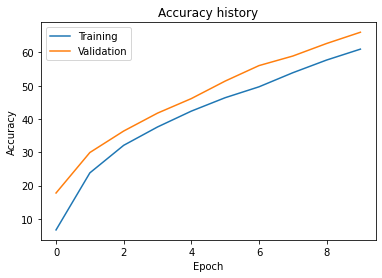

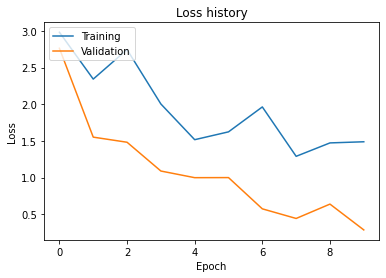

In [10]:
CUDA_LAUNCH_BLOCKING="1"


def update_lr(optimizer, lr):
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

# store best model and acc
best_model_name = 'bestmodel_alexnet_imagenet.ckpt'
best_model = None
best_val_acc = 0.


loss_history = []
val_loss_history = []
train_acc_history = []
val_acc_history = []

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params_to_update, lr=learning_rate)
# Train the model
lr = learning_rate
total_step = len(dermnet_train_data_loader)

for epoch in range(num_epochs):
    correct = 0
    total = 0 
    for i, (images, labels) in enumerate(dermnet_train_data_loader):
        # Move tensors to the configured device
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images).to(device)
        #predicted = torch.where(torch.sigmoid(outputs.data) > 0.5, 1, 0)
        _, predicted = torch.max(outputs.data, 1) 
        loss = criterion(outputs, labels) # labels are stored as float need cast to int

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 10 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    print('Train accuracy is: {} %'.format(100 * correct / total))
    train_acc_history.append(100 * correct / total)
    loss_history.append(loss.item())
    
    # Code to update the lr
    lr *= learning_rate_decay
    update_lr(optimizer, lr)
    
    with torch.no_grad():
        model.eval()
        correct = 0
        total = 0
        for images, labels in dermnet_test_data_loader:
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images).to(device)
            _, predicted = torch.max(outputs.data, 1) 
            #predicted = torch.where(torch.sigmoid(outputs.data) > 0.5, 1, 0)
            
            loss = criterion(outputs, labels)
            
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
        val_accuracy = 100 * correct / total
        if val_accuracy > best_val_acc:
            best_val_acc = val_accuracy
            best_model = model
            torch.save(model.state_dict(), './bestmodel.ckpt')
            print("New best validation accuracy: {} %".format(best_val_acc))


        print('Validataion accuracy is: {} %'.format(100 * correct / total))
        val_acc_history.append(val_accuracy)
        val_loss_history.append(loss.item())
  
plt.plot(train_acc_history)
plt.plot(val_acc_history)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy history')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.show()

# plot the loss history
plt.plot(loss_history)
plt.plot(val_loss_history)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss history')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.show()

### Create Model

###Model Class ResNet50

In [10]:
from torchvision import models
#from torchvision.models import ResNet50_Weights

layer_config= [2048, 512, 256]
num_classes = 1
num_epochs = 30
batch_size = 200
learning_rate = 1e-5
learning_rate_decay = 0.99

# Create ResNet 50 model pretrained with ImageNet
class ResNet50(nn.Module):
    def __init__(self, n_class, fine_tune, pretrained=True):
        super(ResNet50, self).__init__()
        self.net = models.resnet50(pretrained=pretrained)
        
        # add new classifier layers
        self.net.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(layer_config[0], layer_config[1]),
            nn.BatchNorm1d(layer_config[1]),
            nn.Dropout(0.4),
            nn.ReLU(),
            nn.Linear(layer_config[1], layer_config[2]),
            nn.BatchNorm1d(layer_config[2]),
            nn.Dropout(0.4),
            nn.ReLU(),
            nn.Linear(layer_config[2], num_classes)
        )       

    def forward(self, x):
        out = self.net(x)
        #return out
        return out.view(-1, 1).squeeze(1).type(torch.FloatTensor) 

# Initialize the model for this run
fine_tune = True
pretrained = True
model= ResNet50(num_classes, fine_tune, pretrained)
print(model)


print("Params to learn:")
if fine_tune:
    params_to_update = []
    for name, param in model.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    params_to_update = model.parameters()
    for name,param in model.named_parameters():
        if param.requires_grad == True:
            print("\t",name)


model.to(device)

ResNet50(
  (net): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0)

ResNet50(
  (net): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0)

###Model Class vgg16

In [19]:
from torchvision import models

layer_config= [2048, 512, 256]
num_classes = 1
num_epochs = 30
batch_size = 200
learning_rate = 1e-5
learning_rate_decay = 0.99

# Create vgg16 model pretrained with ImageNet
class vgg16(nn.Module):
    def __init__(self, n_class, fine_tune, pretrained=True):
        super(vgg16, self).__init__()
        self.net = models.vgg16(pretrained=pretrained)
        
        # add new classifier layers
        self.net.classifier[6] = (nn.Sequential(
            nn.Linear(4096, layer_config[0]),
            nn.BatchNorm1d(layer_config[0]),
            nn.Dropout(0.4),
            nn.ReLU(),
            nn.Linear(layer_config[0], layer_config[1]),
            nn.BatchNorm1d(layer_config[1]),
            nn.Dropout(0.4),
            nn.ReLU(),
            nn.Linear(layer_config[1], layer_config[2]),
            nn.BatchNorm1d(layer_config[2]),
            nn.Dropout(0.4),
            nn.ReLU(),
            nn.Linear(layer_config[2], 1)
        ))       

    def forward(self, x):
        out = self.net(x)
        #return out
        return out.view(-1, 1).squeeze(1).type(torch.FloatTensor) 

# Initialize the model for this run
fine_tune = True
pretrained = True
model= vgg16(num_classes, fine_tune, pretrained)
print(model)


print("Params to learn:")
if fine_tune:
    params_to_update = []
    for name, param in model.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    params_to_update = model.parameters()
    for name,param in model.named_parameters():
        if param.requires_grad == True:
            print("\t",name)


model.to(device)

vgg16(
  (net): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=True)
      (16): MaxP

vgg16(
  (net): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=True)
      (16): MaxP

###Model Class MobileNet2

In [15]:
from torchvision import models

layer_config= [2048, 512, 256]
num_classes = 1
num_epochs = 30
batch_size = 200
learning_rate = 1e-5
learning_rate_decay = 0.99

# Create mobilenet2 model pretrained with ImageNet
class mobilenet_v2(nn.Module):
    def __init__(self, n_class, fine_tune, pretrained=True):
        super(mobilenet_v2, self).__init__()
        self.net = models.mobilenet_v2(pretrained=pretrained)
        
        # add new classifier layers
        '''self.net.classifier[6] = (nn.Sequential(
            nn.Linear(4096, layer_config[0]),
            nn.BatchNorm1d(layer_config[0]),
            nn.Dropout(0.4),
            nn.ReLU(),
            nn.Linear(layer_config[0], layer_config[1]),
            nn.BatchNorm1d(layer_config[1]),
            nn.Dropout(0.4),
            nn.ReLU(),
            nn.Linear(layer_config[1], layer_config[2]),
            nn.BatchNorm1d(layer_config[2]),
            nn.Dropout(0.4),
            nn.ReLU(),
            nn.Linear(layer_config[2], 1)
        )) '''      

    def forward(self, x):
        out = self.net(x)
        #return out
        return out.view(-1, 1).squeeze(1).type(torch.FloatTensor) 

# Initialize the model for this run
fine_tune = True
pretrained = True
model= vgg16(num_classes, fine_tune, pretrained)
print(model)


print("Params to learn:")
if fine_tune:
    params_to_update = []
    for name, param in model.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    params_to_update = model.parameters()
    for name,param in model.named_parameters():
        if param.requires_grad == True:
            print("\t",name)


model.to(device)

vgg16(
  (net): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=True)
      (16): MaxP

vgg16(
  (net): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=True)
      (16): MaxP

### Model CLass Alexnet

In [13]:
from torchvision import models

layer_config= [2048, 512, 256]
num_classes = 1
num_epochs = 30
batch_size = 200
learning_rate = 1e-5
learning_rate_decay = 0.99

# Create alexnet model pretrained with ImageNet
class alexnet(nn.Module):
    def __init__(self, n_class, fine_tune, pretrained=True):
        super(alexnet, self).__init__()
        self.net = models.alexnet(pretrained=pretrained)
        
        # add new classifier layers
        self.net.classifier[6] = (nn.Sequential(
            nn.Linear(4096, layer_config[0]),
            nn.BatchNorm1d(layer_config[0]),
            nn.Dropout(0.4),
            nn.ReLU(),
            nn.Linear(layer_config[0], layer_config[1]),
            nn.BatchNorm1d(layer_config[1]),
            nn.Dropout(0.4),
            nn.ReLU(),
            nn.Linear(layer_config[1], layer_config[2]),
            nn.BatchNorm1d(layer_config[2]),
            nn.Dropout(0.4),
            nn.ReLU(),
            nn.Linear(layer_config[2], num_classes)
        ))      

    def forward(self, x):
        out = self.net(x)
        #return out.type(torch.FloatTensor)
        return out.view(-1, 1).squeeze(1).type(torch.FloatTensor) 

# Initialize the model for this run
fine_tune = True
pretrained = True
model= alexnet(num_classes, fine_tune, pretrained)
print(model)


print("Params to learn:")
if fine_tune:
    params_to_update = []
    for name, param in model.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    params_to_update = model.parameters()
    for name,param in model.named_parameters():
        if param.requires_grad == True:
            print("\t",name)


model.to(device)

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

alexnet(
  (net): AlexNet(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
      (1): ReLU(inplace=True)
      (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (4): ReLU(inplace=True)
      (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): ReLU(inplace=True)
      (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (9): ReLU(inplace=True)
      (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
    (classifier): Sequential(
      (0): Dropout(p=0.5, inplace=False)
      (1): 

alexnet(
  (net): AlexNet(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
      (1): ReLU(inplace=True)
      (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (4): ReLU(inplace=True)
      (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): ReLU(inplace=True)
      (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (9): ReLU(inplace=True)
      (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
    (classifier): Sequential(
      (0): Dropout(p=0.5, inplace=False)
      (1): 

# Finetuning

###Finetuning Resnet50

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch [1/30], Step [10/18], Loss: 0.6266
Train accuracy is: 58.8235294117647 %
New best validation accuracy: 59.770114942528735 %
Validataion accuracy is: 59.770114942528735 %
Epoch [2/30], Step [10/18], Loss: 0.6043
Train accuracy is: 72.54901960784314 %
New best validation accuracy: 70.11494252873563 %
Validataion accuracy is: 70.11494252873563 %
Epoch [3/30], Step [10/18], Loss: 0.3625
Train accuracy is: 74.78991596638656 %
New best validation accuracy: 83.9080459770115 %
Validataion accuracy is: 83.9080459770115 %
Epoch [4/30], Step [10/18], Loss: 0.2725
Train accuracy is: 84.31372549019608 %
New best validation accuracy: 89.65517241379311 %
Validataion accuracy is: 89.65517241379311 %
Epoch [5/30], Step [10/18], Loss: 0.3677
Train accuracy is: 88.23529411764706 %
Validataion accuracy is: 83.9080459770115 %
Epoch [6/30], Step [10/18], Loss: 0.3718
Train accuracy is: 89.35574229691876 %
Validataion accuracy is: 83.9080459770115 %
Epoch [7/30], Step [10/18], Loss: 0.1942
Train accura

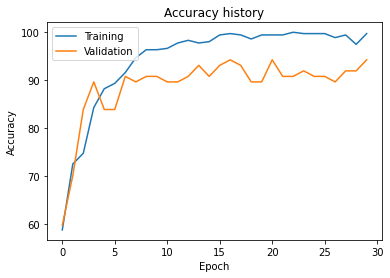

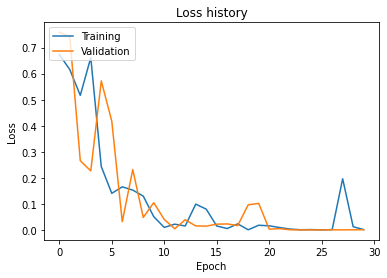

In [12]:
CUDA_LAUNCH_BLOCKING="1"


def update_lr(optimizer, lr):
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

# store best model and acc
best_model_name = 'bestmodel_resnet50.ckpt'
best_model = None
best_val_acc = 0.


loss_history = []
val_loss_history = []
train_acc_history = []
val_acc_history = []

# Loss and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(params_to_update, lr=learning_rate)
# Train the model
lr = learning_rate
total_step = len(lyme_train_data_loader)

for epoch in range(num_epochs):
    correct = 0
    total = 0 
    for i, (images, labels) in enumerate(lyme_train_data_loader):
        # Move tensors to the configured device
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images).to(device)
        predicted = torch.where(torch.sigmoid(outputs.data) > 0.5, 1, 0)
        loss = criterion(outputs, labels.float()) # labels are stored as float need cast to int

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 10 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    print('Train accuracy is: {} %'.format(100 * correct / total))
    train_acc_history.append(100 * correct / total)
    loss_history.append(loss.item())
    
    # Code to update the lr
    lr *= learning_rate_decay
    update_lr(optimizer, lr)
    
    with torch.no_grad():
        model.eval()
        correct = 0
        total = 0
        for images, labels in lyme_test_data_loader:
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images).to(device)
            predicted = torch.where(torch.sigmoid(outputs.data) > 0.5, 1, 0)
            
            loss = criterion(outputs, labels.float())
            
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
        val_accuracy = 100 * correct / total
        if val_accuracy > best_val_acc:
            best_val_acc = val_accuracy
            best_model = model
            torch.save(model.state_dict(), best_model_name)
            print("New best validation accuracy: {} %".format(best_val_acc))


        print('Validataion accuracy is: {} %'.format(100 * correct / total))
        val_acc_history.append(val_accuracy)
        val_loss_history.append(loss.item())
  
plt.plot(train_acc_history)
plt.plot(val_acc_history)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy history')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.show()

# plot the loss history
plt.plot(loss_history)
plt.plot(val_loss_history)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss history')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.show()

###Finetuning AlexNet

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch [1/30], Step [10/18], Loss: 0.6841
Train accuracy is: 55.182072829131656 %
New best validation accuracy: 58.62068965517241 %
Validataion accuracy is: 58.62068965517241 %
Epoch [2/30], Step [10/18], Loss: 0.6643
Train accuracy is: 60.50420168067227 %
Validataion accuracy is: 58.62068965517241 %
Epoch [3/30], Step [10/18], Loss: 0.6895
Train accuracy is: 60.78431372549019 %
Validataion accuracy is: 58.62068965517241 %
Epoch [4/30], Step [10/18], Loss: 0.6207
Train accuracy is: 61.904761904761905 %
New best validation accuracy: 59.770114942528735 %
Validataion accuracy is: 59.770114942528735 %
Epoch [5/30], Step [10/18], Loss: 0.5662
Train accuracy is: 62.745098039215684 %
New best validation accuracy: 60.91954022988506 %
Validataion accuracy is: 60.91954022988506 %
Epoch [6/30], Step [10/18], Loss: 0.5831
Train accuracy is: 69.74789915966386 %
Validataion accuracy is: 59.770114942528735 %
Epoch [7/30], Step [10/18], Loss: 0.6339
Train accuracy is: 76.47058823529412 %
New best valid

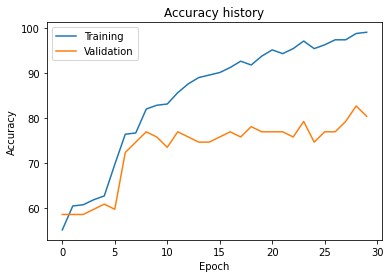

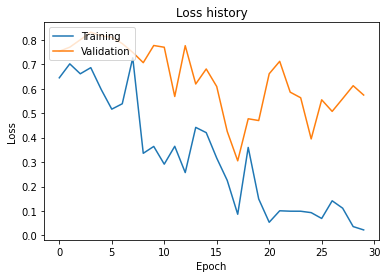

In [14]:
CUDA_LAUNCH_BLOCKING="1"


def update_lr(optimizer, lr):
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

# store best model and acc
best_model_name = 'bestmodel_alexnet.ckpt'
best_model = None
best_val_acc = 0.


loss_history = []
val_loss_history = []
train_acc_history = []
val_acc_history = []

# Loss and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(params_to_update, lr=learning_rate)
# Train the model
lr = learning_rate
total_step = len(lyme_train_data_loader)

for epoch in range(num_epochs):
    correct = 0
    total = 0 
    for i, (images, labels) in enumerate(lyme_train_data_loader):
        # Move tensors to the configured device
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images).to(device)
        predicted = torch.where(torch.sigmoid(outputs.data) > 0.5, 1, 0)
        loss = criterion(outputs, labels.float()) # labels are stored as float need cast to int

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 10 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    print('Train accuracy is: {} %'.format(100 * correct / total))
    train_acc_history.append(100 * correct / total)
    loss_history.append(loss.item())
    
    # Code to update the lr
    lr *= learning_rate_decay
    update_lr(optimizer, lr)
    
    with torch.no_grad():
        model.eval()
        correct = 0
        total = 0
        for images, labels in lyme_test_data_loader:
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images).to(device)
            predicted = torch.where(torch.sigmoid(outputs.data) > 0.5, 1, 0)
            
            loss = criterion(outputs, labels.float())
            
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
        val_accuracy = 100 * correct / total
        if val_accuracy > best_val_acc:
            best_val_acc = val_accuracy
            best_model = model
            torch.save(model.state_dict(), best_model_name)
            print("New best validation accuracy: {} %".format(best_val_acc))


        print('Validataion accuracy is: {} %'.format(100 * correct / total))
        val_acc_history.append(val_accuracy)
        val_loss_history.append(loss.item())
  
plt.plot(train_acc_history)
plt.plot(val_acc_history)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy history')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.show()

# plot the loss history
plt.plot(loss_history)
plt.plot(val_loss_history)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss history')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.show()

###Finetuning with Mobilenetv2

Epoch [1/30], Step [10/18], Loss: 0.7487


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train accuracy is: 47.338935574229694 %
New best validation accuracy: 51.724137931034484 %
Validataion accuracy is: 51.724137931034484 %
Epoch [2/30], Step [10/18], Loss: 0.6828
Train accuracy is: 60.22408963585434 %
New best validation accuracy: 57.47126436781609 %
Validataion accuracy is: 57.47126436781609 %
Epoch [3/30], Step [10/18], Loss: 0.6884
Train accuracy is: 61.06442577030813 %
New best validation accuracy: 60.91954022988506 %
Validataion accuracy is: 60.91954022988506 %
Epoch [4/30], Step [10/18], Loss: 0.6456
Train accuracy is: 59.38375350140056 %
Validataion accuracy is: 59.770114942528735 %
Epoch [5/30], Step [10/18], Loss: 0.6270
Train accuracy is: 64.70588235294117 %
New best validation accuracy: 67.816091954023 %
Validataion accuracy is: 67.816091954023 %
Epoch [6/30], Step [10/18], Loss: 0.5511
Train accuracy is: 72.82913165266106 %
New best validation accuracy: 72.41379310344827 %
Validataion accuracy is: 72.41379310344827 %
Epoch [7/30], Step [10/18], Loss: 0.5205


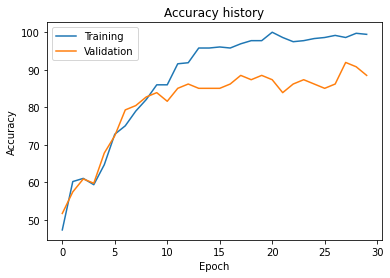

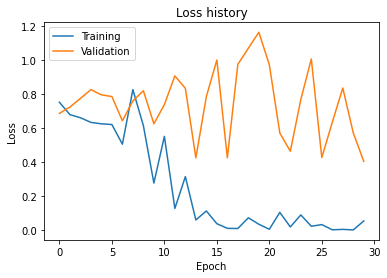

In [16]:
CUDA_LAUNCH_BLOCKING="1"


def update_lr(optimizer, lr):
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

# store best model and acc
best_model_name = 'bestmodel_mobilenetv2.ckpt'
best_model = None
best_val_acc = 0.


loss_history = []
val_loss_history = []
train_acc_history = []
val_acc_history = []

# Loss and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(params_to_update, lr=learning_rate)
# Train the model
lr = learning_rate
total_step = len(lyme_train_data_loader)

for epoch in range(num_epochs):
    correct = 0
    total = 0 
    for i, (images, labels) in enumerate(lyme_train_data_loader):
        # Move tensors to the configured device
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images).to(device)
        predicted = torch.where(torch.sigmoid(outputs.data) > 0.5, 1, 0)
        loss = criterion(outputs, labels.float()) # labels are stored as float need cast to int

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 10 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    print('Train accuracy is: {} %'.format(100 * correct / total))
    train_acc_history.append(100 * correct / total)
    loss_history.append(loss.item())
    
    # Code to update the lr
    lr *= learning_rate_decay
    update_lr(optimizer, lr)
    
    with torch.no_grad():
        model.eval()
        correct = 0
        total = 0
        for images, labels in lyme_test_data_loader:
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images).to(device)
            predicted = torch.where(torch.sigmoid(outputs.data) > 0.5, 1, 0)
            
            loss = criterion(outputs, labels.float())
            
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
        val_accuracy = 100 * correct / total
        if val_accuracy > best_val_acc:
            best_val_acc = val_accuracy
            best_model = model
            torch.save(model.state_dict(), best_model_name)
            print("New best validation accuracy: {} %".format(best_val_acc))


        print('Validataion accuracy is: {} %'.format(100 * correct / total))
        val_acc_history.append(val_accuracy)
        val_loss_history.append(loss.item())
  
plt.plot(train_acc_history)
plt.plot(val_acc_history)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy history')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.show()

# plot the loss history
plt.plot(loss_history)
plt.plot(val_loss_history)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss history')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.show()

###Finetuning vgg16

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch [1/30], Step [10/18], Loss: 0.5343
Train accuracy is: 57.703081232493 %
New best validation accuracy: 58.62068965517241 %
Validataion accuracy is: 58.62068965517241 %
Epoch [2/30], Step [10/18], Loss: 0.6616
Train accuracy is: 57.703081232493 %
Validataion accuracy is: 58.62068965517241 %
Epoch [3/30], Step [10/18], Loss: 0.6189
Train accuracy is: 57.703081232493 %
Validataion accuracy is: 58.62068965517241 %
Epoch [4/30], Step [10/18], Loss: 0.6378
Train accuracy is: 57.703081232493 %
Validataion accuracy is: 58.62068965517241 %
Epoch [5/30], Step [10/18], Loss: 0.6421
Train accuracy is: 58.26330532212885 %
New best validation accuracy: 60.91954022988506 %
Validataion accuracy is: 60.91954022988506 %
Epoch [6/30], Step [10/18], Loss: 0.6360
Train accuracy is: 64.14565826330532 %
New best validation accuracy: 68.96551724137932 %
Validataion accuracy is: 68.96551724137932 %
Epoch [7/30], Step [10/18], Loss: 0.6409
Train accuracy is: 71.42857142857143 %
New best validation accuracy

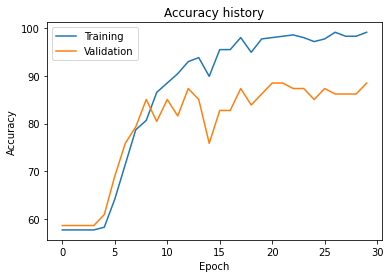

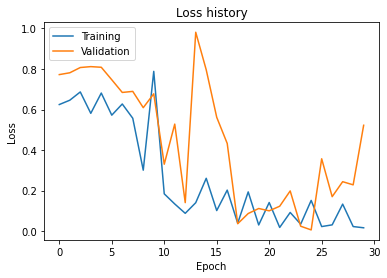

In [20]:
CUDA_LAUNCH_BLOCKING="1"


def update_lr(optimizer, lr):
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

# store best model and acc
best_model_name = 'bestmodel_vgg16.ckpt'
best_model = None
best_val_acc = 0.


loss_history = []
val_loss_history = []
train_acc_history = []
val_acc_history = []

# Loss and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(params_to_update, lr=learning_rate)
# Train the model
lr = learning_rate
total_step = len(lyme_train_data_loader)

for epoch in range(num_epochs):
    correct = 0
    total = 0 
    for i, (images, labels) in enumerate(lyme_train_data_loader):
        # Move tensors to the configured device
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images).to(device)
        predicted = torch.where(torch.sigmoid(outputs.data) > 0.5, 1, 0)
        loss = criterion(outputs, labels.float()) # labels are stored as float need cast to int

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 10 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    print('Train accuracy is: {} %'.format(100 * correct / total))
    train_acc_history.append(100 * correct / total)
    loss_history.append(loss.item())
    
    # Code to update the lr
    lr *= learning_rate_decay
    update_lr(optimizer, lr)
    
    with torch.no_grad():
        model.eval()
        correct = 0
        total = 0
        for images, labels in lyme_test_data_loader:
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images).to(device)
            predicted = torch.where(torch.sigmoid(outputs.data) > 0.5, 1, 0)
            
            loss = criterion(outputs, labels.float())
            
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
        val_accuracy = 100 * correct / total
        if val_accuracy > best_val_acc:
            best_val_acc = val_accuracy
            best_model = model
            torch.save(model.state_dict(), best_model_name)
            print("New best validation accuracy: {} %".format(best_val_acc))


        print('Validataion accuracy is: {} %'.format(100 * correct / total))
        val_acc_history.append(val_accuracy)
        val_loss_history.append(loss.item())
  
plt.plot(train_acc_history)
plt.plot(val_acc_history)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy history')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.show()

# plot the loss history
plt.plot(loss_history)
plt.plot(val_loss_history)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss history')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.show()

In [30]:
!cp './bestmodel_vgg16.ckpt' './drive/MyDrive/checkpoints'